https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

In [ ]:
# Colab's file access feature
from google.colab import files

# Upload `kaggle.json` file
uploaded = files.upload()

# Then copy kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 110MB/s]


In [ ]:
!unzip '/content/news-headlines-dataset-for-sarcasm-detection.zip'

Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [ ]:
import pandas as pd


In [ ]:
df1=pd.read_json('/content/Sarcasm_Headlines_Dataset.json',lines=True)

In [ ]:
df2=pd.read_json('/content/Sarcasm_Headlines_Dataset_v2.json',lines=True)

In [ ]:
df3=pd.concat([df1,df2])

In [ ]:
df3

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
28614,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
28615,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
28616,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
28617,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg-gat...,1


In [ ]:

line_length=df3['headline'].apply(lambda x : len(x.split())).values

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


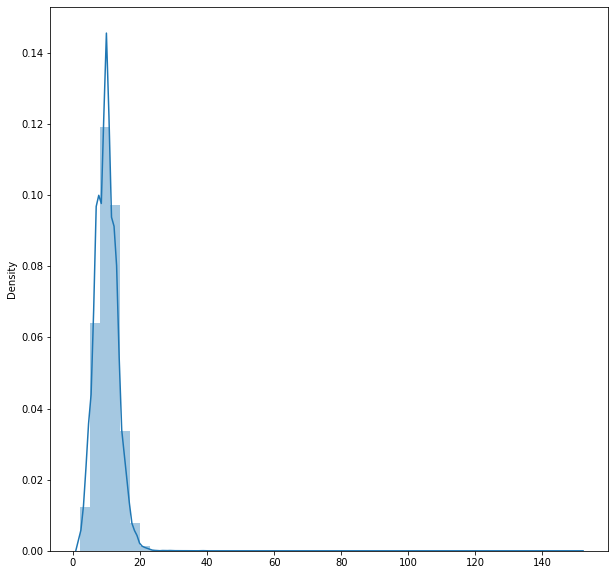

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(line_length)


In [ ]:
seq_length=30


In [ ]:
pip install transformers

     |████████████████████████████████| 1.8MB 17.0MB/s 
     |████████████████████████████████| 2.9MB 43.5MB/s 
     |████████████████████████████████| 890kB 43.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ce9a2a76fc3cfdfb277269d6011880c03630e477df287d5845287e185d1a9ce9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
import numpy as np


In [ ]:
tokens = tokenizer.encode_plus('hello world', max_length = seq_length,
                                truncation = True, padding = "max_length",
                                add_special_tokens= True, return_token_type_ids = False,
                                return_attention_mask = True, return_tensors='tf')
tokens

{'input_ids': <tf.Tensor: shape=(1, 30), dtype=int32, numpy=
array([[  101, 19082,  1362,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 30), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [ ]:
x_sequence=np.zeros((len(df3),seq_length))
x_mask=np.zeros((len(df3),seq_length))
for i,phrase in enumerate(df3['headline']):
  tokens = tokenizer.encode_plus(phrase, max_length = seq_length,
                                truncation = True, padding = "max_length",
                                add_special_tokens= True, return_token_type_ids = False,
                                return_attention_mask = True, return_tensors='tf')
  x_sequence[i]=tokens['input_ids']
  x_mask[i]=tokens['attention_mask']
x_sequence,x_mask

(array([[  101.,  1393., 21003., ...,     0.,     0.,     0.],
        [  101.,  1103.,   112., ...,     0.,     0.,     0.],
        [  101.,  4113.,  2547., ...,     0.,     0.,     0.],
        ...,
        [  101.,  1103.,  1211., ...,     0.,     0.,     0.],
        [  101., 12477.,  1733., ...,     0.,     0.,     0.],
        [  101.,  4153.,   172., ...,     0.,     0.,     0.]]),
 array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]))

In [ ]:
labels=df3['is_sarcastic'].values
labels=np.reshape(labels,(55328,1))

In [ ]:
import tensorflow as tf

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_sequence, x_mask, labels))

In [ ]:
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([  101.,  1393., 21003.,  2093.,  2984.,  9477., 25762.,  1116.,
        1166.,  3318.,   112.,  1602.,  3463.,   112.,  1111.,  7309.,
        4130.,  6206.,   102.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.])>, <tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>)


In [ ]:
def map_func(input_ids, masks, labels):
  return {"input_ids" : input_ids, "attention_mask" : masks}, labels

dataset = dataset.map(map_func)

for i in dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(30,), dtype=float64, numpy=
array([  101.,  1393., 21003.,  2093.,  2984.,  9477., 25762.,  1116.,
        1166.,  3318.,   112.,  1602.,  3463.,   112.,  1111.,  7309.,
        4130.,  6206.,   102.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.])>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>}, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>)


In [ ]:
dataset = dataset.shuffle(100000).batch(32)

In [ ]:
len(list(dataset))

1729

In [ ]:
x_train=dataset.take(round(0.9*1729))

In [ ]:
x_test=dataset.skip(round(0.9*1729))

In [ ]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, Model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Input, GlobalMaxPooling1D,BatchNormalization


In [ ]:
seq_length

30

In [ ]:
input_ids=Input(shape=(seq_length),name='input_ids',dtype='int32')
attention_mask=Input(shape=(seq_length),name='attention_mask',dtype='int32')
embeddings=bert.bert(input_ids,attention_mask)[0]
x=GlobalMaxPooling1D()(embeddings)
x=BatchNormalization()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model=Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable=False
model.summary()





Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           bert[0][0]                   

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(x_test,validation_data=x_test, epochs=100, verbose=1)

Epoch 1/100
173/173 [==============================] - 32s 144ms/step - loss: 0.6131 - acc: 0.6615 - val_loss: 0.4869 - val_acc: 0.7634
Epoch 2/100
173/173 [==============================] - 24s 138ms/step - loss: 0.4619 - acc: 0.7809 - val_loss: 0.4131 - val_acc: 0.8152
Epoch 3/100
173/173 [==============================] - 23s 134ms/step - loss: 0.4206 - acc: 0.8038 - val_loss: 0.4083 - val_acc: 0.8152
Epoch 4/100
173/173 [==============================] - 23s 134ms/step - loss: 0.4180 - acc: 0.8081 - val_loss: 0.3921 - val_acc: 0.8228
Epoch 5/100
173/173 [==============================] - 23s 135ms/step - loss: 0.4222 - acc: 0.8051 - val_loss: 0.3693 - val_acc: 0.8333
Epoch 6/100
173/173 [==============================] - 23s 135ms/step - loss: 0.4143 - acc: 0.8100 - val_loss: 0.3535 - val_acc: 0.8430
Epoch 7/100
173/173 [==============================] - 23s 134ms/step - loss: 0.4097 - acc: 0.8118 - val_loss: 0.3559 - val_acc: 0.8376
Epoch 8/100
173/173 [===========================

In [ ]:
model.save('/content/saved_model.h5')

In [ ]:
model2=tf.keras.models.load_model('/content/saved_model.h5')

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           bert[0][0]                   

In [ ]:
samp_txt='i work 40 hours a week to be this poor'
print(samp_txt)

i work 40 hours a week to be this poor


In [ ]:
tokens = tokenizer.encode_plus(samp_txt, max_length = seq_length,
                                truncation = True, padding = "max_length",
                                add_special_tokens= True, return_token_type_ids = False,
                                return_attention_mask = True, return_tensors='tf')
tokens
x_sequence_1=tokens['input_ids']
x_mask_1=tokens['attention_mask']

In [ ]:
y_pred=model2.predict((x_sequence_1,x_mask_1))

In [ ]:
if(y_pred>0.5):
  print('sarcasm')
else:
  print('not sarcasm')

not sarcasm


In [ ]:
pred_=model.predict((x_sequence_1,x_mask_1))

In [ ]:
if(pred_>0.5):
  print('sarcasm')
else:
  print('not sarcasm')

not sarcasm


In [ ]:
jh=df3['headline'].values[26]
jh


'obama visits arlington national cemetery to honor veterans'

In [ ]:
arr=df3['is_sarcastic'].values

In [ ]:
len(y)

55328

In [ ]:
rslt_df = df3.loc[df3['is_sarcastic'] > 0] 

In [ ]:
for i in range(1,100):
  print(rslt_df['headline'].values[i])

boehner just wants wife to listen, not come up with alternative debt-reduction ideas
top snake handler leaves sinking huckabee campaign
nuclear bomb detonates during rehearsal for 'spider-man' musical
cosby lawyer asks why accusers didn't come forward to be smeared by legal team years ago
stock analysts confused, frightened by boar market
courtroom sketch artist has clear manga influences
trump assures nation that decision for syrian airstrikes came after carefully considering all his passing whims
ex-con back behind bar
after careful consideration, bush recommends oil drilling
giant altoid heading toward earth
robin williams inflicted on holiday moviegoers for eighth straight year
rescuers heroically help beached garbage back into ocean
christian bale visits sikh temple victims
'right to live life in complete, stunned horror,' added to constitution
nasa now almost positive mars is rocky
monster undeterred by night-light
longtime teacher retires without changing a single student's life